In [301]:
using Plots, BenchmarkTools, Sobol, KahanSummation

In [302]:
s = SobolSeq(2)

2-dimensional Sobol sequence on [0,1]^2

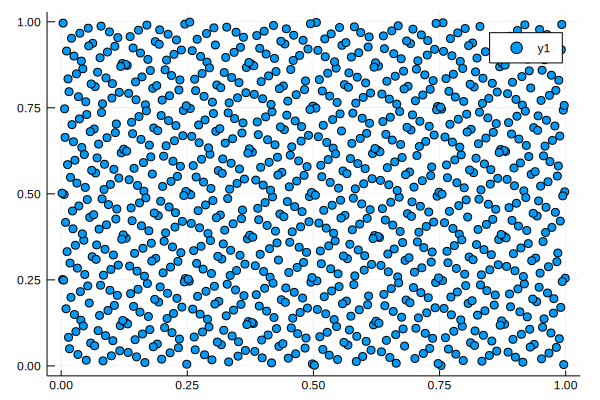

In [303]:
n = 1000
points = zeros(Float64,(2,n))
for i = 1:n
    points[:,i] .= next!(s)
end
scatter(points[1,:], points[2,:])

In [304]:
"""
Solve ``P(x) = \\frac{2\\pi R}{k} ``

```math
P(x) = \\int_0^x (1 + \\alpha cos(k y)) dy
```
```math
P(x) = x + \\frac{\\alpha}{k} sin (k x)
```

"""
function dichotomie(R)
    
    kx, alpha = 0.5, 0.1
    eps = 1e-12
    a, b = 0, 2π/kx
    while true
        x = 0.5 * (a+b)
        D = ( kx * x + alpha * sin(kx*x)) / 2π
        if ( D<R-eps )
           a = x
        elseif ( D>R+eps )
           b = x
        else
           return x
        end
    end
end

dichotomie

In [305]:
"""

Input r is a random number ``\\in [0,1]``

```math
    f(x) = 1 + \\alpha cos(k x)
```
on some domain ``[0, 2\\pi/k]``

Solve the equation ``P(x)-r=0`` with Newton’s method

```math
    x^{n+1} = x^n – (P(x)-(2\\pi r / k)/f(x) 
```

with 
```math
P(x) = \\int_0^x (1 + \\alpha cos(k y)) dy
```
```math
P(x) = x + \\frac{\\alpha}{k} sin (k x)
```
"""
function newton(r)
    x0, x1 = 0.0, 1.0
    alpha, k = 0.1, 0.5
    r *= 2 * pi / k
    while (abs(x1-x0) > 1e-12)
        p = x0 + alpha * sin( k * x0) / k 
        f = 1 + alpha * cos( k * x0)
        x0, x1 = x1, x0 - (p - r) / f
    end
    x1
end

newton

In [306]:
?newton

search: newton



Input r is a random number $\in [0,1]$

$$
    f(x) = 1 + \alpha cos(k x)
$$

on some domain $[0, 2\pi/k]$

Solve the equation $P(x)-r=0$ with Newton’s method

$$
    x^{n+1} = x^n – (P(x)-(2\pi r / k)/f(x) 
$$

with 

$$
P(x) = \int_0^x (1 + \alpha cos(k y)) dy
$$

$$
P(x) = x + \frac{\alpha}{k} sin (k x)
$$


In [307]:
@btime newton(0.9)

  150.600 ns (0 allocations: 0 bytes)


11.418335561722728

In [308]:
?dichotomie

search: dichotomie



Solve $P(x) = \frac{2\pi R}{k}$

$$
P(x) = \int_0^x (1 + \alpha cos(k y)) dy
$$

$$
P(x) = x + \frac{\alpha}{k} sin (k x)
$$


In [309]:
@btime dichotomie(0.9)

  494.711 ns (0 allocations: 0 bytes)


11.418335561725414

In [310]:
function landau( nbpart :: Int64)
    
   xp = Float64[]
   vp = Float64[]
    
   s = SobolSeq(2)

   for k=0:nbpart-1

      v = sqrt(-2 * log( (k+0.5)/nbpart))
      r1, r2 = next!(s)
      θ = r1 * 2π
      push!(xp,  newton(r2))
      push!(vp,  v * sin(θ))

   end

   xp, vp
    
end

landau (generic function with 1 method)

In [311]:
xp, vp = landau(100000);

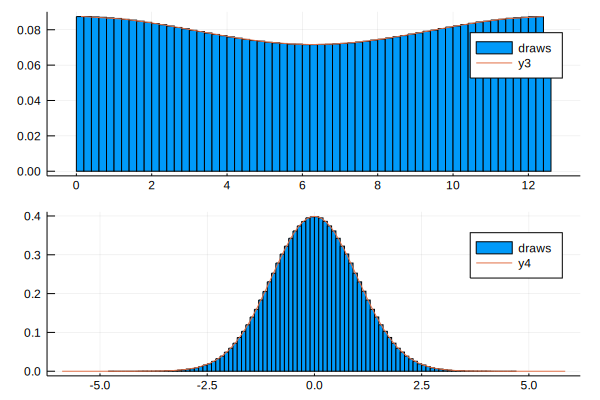

In [312]:
p = histogram([xp,vp], normalize=true, bins = 100,  layout=(2,1), lab = "draws")
plot!(p[1,1], x-> (1+0.1*cos(0.5*x))/4π, 0., 4π)
plot!(p[2,1], x-> (exp(-x^2/2))/sqrt(2π), -6, 6)

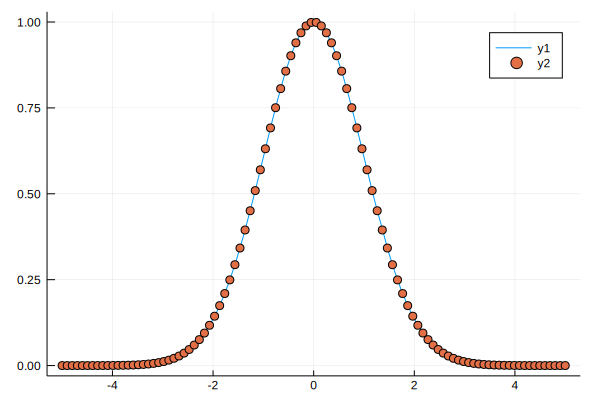

In [313]:
ρ(x) = exp(-x^2/2)
xmin, xmax, nx = -5, 5, 100
x = range( xmin, stop=xmax, length=nx)
f = map(ρ, x)
plot(ρ, xmin, xmax)
scatter!(x, f)

nx * dx == xmax - xmin = false


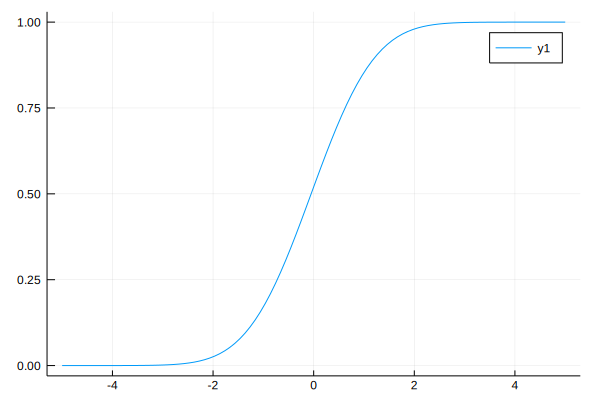

In [314]:
dx = (xmax - xmin)/(nx-1)
@show nx * dx == xmax - xmin
v = (cumsum(f) .* dx) / sqrt(2π)
plot( x, v)

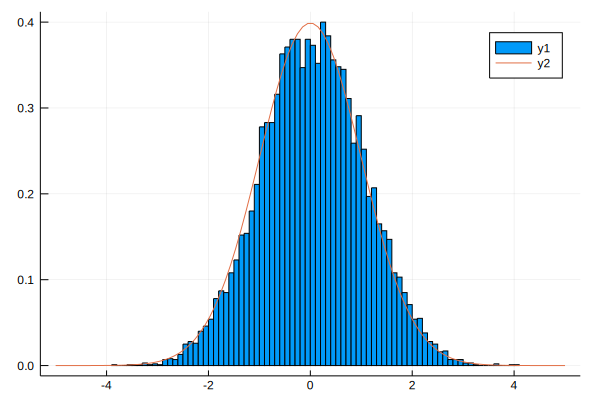

In [315]:
samples  = rand(10000) 
for i in eachindex(samples)
    j = findmin(abs.(v .- samples[i] ))[2]
    samples[i] =  xmin + j * dx
end
histogram(samples, normalize=true, bins = 100)
plot!(x, f ./ sqrt(2π))

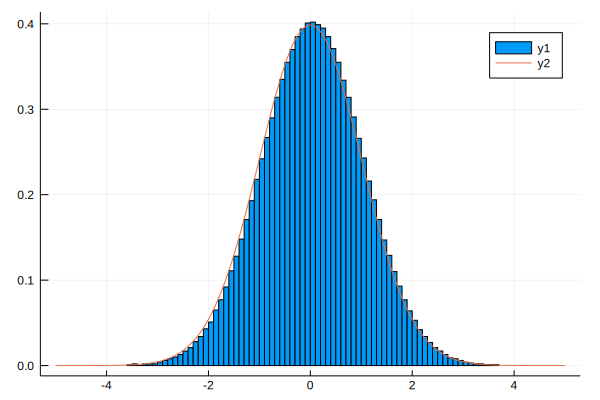

In [316]:
s = SobolSeq(1)
for i in eachindex(samples)
    rnd = next!(s)[1]
    j = findmin(abs.(v .- rnd ))[2]
    samples[i] =  xmin + j * dx
end
histogram(samples, normalize=true, bins = 100)
plot!(x, f ./ sqrt(2π))

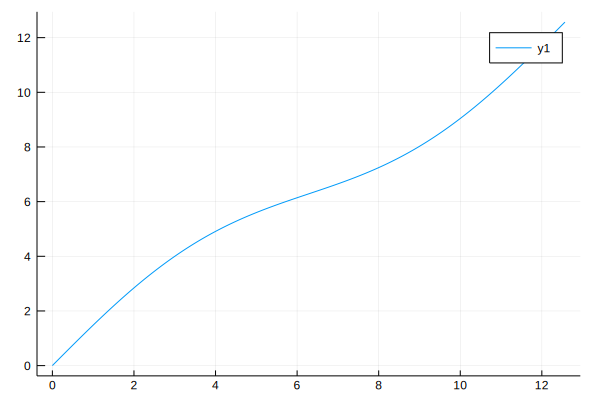

In [344]:
alpha, kx = 0.5, 0.5
xmin, xmax, nx = 0.0, 2π/kx, 10000
dx = (xmax - xmin) / (nx-1)
x = range(xmin, stop=xmax, length=nx) |> collect
f = 1 .+ alpha*cos.(kx .* x)
v = cumsum(f)*dx 
plot(x, v)

Construct the CDF numerically and find the closest value 

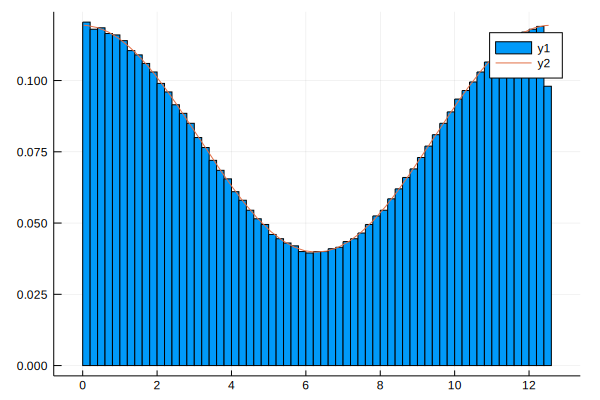

In [345]:
nbpart = 10000
s  = SobolSeq(1)
xp = Float64[]
for k=0:nbpart-1
   r = next!(s)[1] * 4π
   j = findmin(abs.(v .- r) )[2]
   push!(xp,  x[j])
end

histogram(xp, normalize=true, bins = 100)
plot!(x-> (1+alpha*cos(kx*x))/4π, 0., 4π)